# 03 Adding a sphere - optimized version

* 기존 예제에서 for loop을 제거하고 numpy의 broadcasting을 이용하여 최적화한 예제입니다.
* gpu를 사용하는 pytorch 등의 연산으로 쉽게 치환할수 있고 더욱 빨라집니다.

In [1]:
import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt

In [2]:
def normalize(vec: np.array, eps: float = 1e-6):
  return vec / (LA.norm(vec, axis=-1, keepdims=True) + eps)

def blend(color1: np.array, color2: np.array, t_map: np.array):
  return (1.0 - t_map)*color1 + t_map*color2

* numpy의 dot(a, b) 함수
  * a와 b가 0차원(스칼라)일 경우, 곱하기 연산
  * a와 b가 1차원일 경우, 내적 연산
  * a와 b가 2차원일 경우, 행렬 곱 연산
  * ...
* 여러 벡터 간의 내적 연산을 위해 dot 함수를 새롭게 정의합니다.
  * 두 벡터의 마지막 dim의 크기가 같아야 합니다. 
  * 예:
    * (10, 3), (10, 3) -> (10, 1)
    * (3), (20, 3) -> (20, 1)
    * (10. 1, 3), (20, 3) -> (10, 20, 1)
    * (10. 5, 3), (20, 3) -> error!

In [3]:
def dot(v1: np.array, v2: np.array) -> np.array:  
  return np.sum(v1*v2, axis=-1, keepdims=True)

In [4]:
class Ray:
  def __init__(self, origin: np.array, direction_map: np.array) -> None:
    self.origin = origin    
    self.direction_map = normalize(direction_map)
    
  def at(self, t_map: np.array) -> np.array:
    return self.origin + t_map*self.direction_map

*  판별식 계산도 broadcasting을 이용해서 수정합니다.

In [5]:
def is_hit_sphere(center: np.array, radius: float, ray: Ray):
  # center: [3]
  # ray.origin: [3]
  # dir_center_to_origin: [3]
  dir_center_to_origin = ray.origin - center  
   
  # ray.direction_map: [h, w, 3]
  # a_map: [h, w, 1]
  a_map = dot(ray.direction_map, ray.direction_map)
  # dir_center_to_origin: [3]
  # ray.direction_map: [h, w, 3]
  # h_map: [h, w, 1]
  half_b_map = dot(dir_center_to_origin, ray.direction_map)
  # dir_center_to_origin: [3]
  # dir_center_to_origin: [3]
  # c_map: [1]
  c_map = dot(dir_center_to_origin, dir_center_to_origin) - radius**2.0

  # h_map: [h, w, 1]
  # a_map: [h, w, 1]
  # c_map: [1]
  # discriminant_map: [h, w, 1]
  discriminant_map = half_b_map**2 - a_map*c_map
  return discriminant_map >= 0

* np.where(cond, x, y)는 cond가 True면 x, False면 y를 반환한다.
  * broadcasting 지원
  * https://numpy.org/doc/stable/reference/generated/numpy.where.html

In [6]:
def ray_color(ray: Ray) -> np.array:
  sphere_center = np.array([0.0, 0.0, -1.0])
  sphere_color = np.array([1.0, 0.0, 0.0])
  hit_map = is_hit_sphere(center=sphere_center, radius=0.5, ray=ray)

  t_map = 0.5*(ray.direction_map[...,1:2] + 1.0)
  color1 = np.array([1.0, 1.0, 1.0])
  color2 = np.array([0.5, 0.7, 1.0])
  background_color = blend(color1=color1, color2=color2, t_map=t_map)

  return np.where(hit_map, sphere_color, background_color)


In [7]:
# image
aspect_ratio = 16.0 / 9.0
image_height = 200
image_width = int(aspect_ratio * image_height)

image = np.zeros([image_height, image_width, 3])

In [8]:
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
frontal_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = camera_origin - horizontal_vec/2.0 - vertical_vec/2.0 - frontal_vec

In [9]:
%%time

us = np.linspace(start=0.0, stop=1.0, num=image_width)
vs = np.linspace(start=0.0, stop=1.0, num=image_height)
u_map, v_map = np.meshgrid(us, vs, indexing="xy")
u_map = u_map[..., np.newaxis]
v_map = v_map[..., np.newaxis]

ray = Ray(origin=camera_origin,
          direction_map=(lower_left_corner + u_map*horizontal_vec + v_map*vertical_vec) - camera_origin)

image = ray_color(ray=ray)

CPU times: user 16.3 ms, sys: 5.08 ms, total: 21.4 ms
Wall time: 19.5 ms


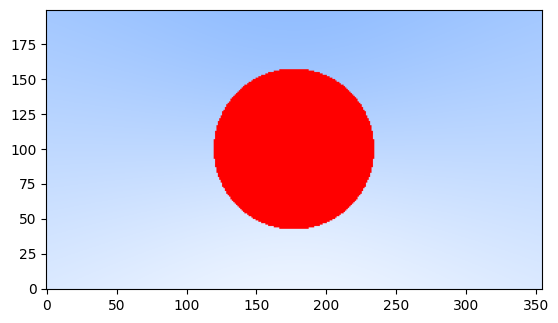

In [10]:
plt.imshow(image, origin='lower')
plt.show()